In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#


# An Initial Look at Phased Verticals

* A simple 1/4&lambda; vertical
* An endfire array with a pair of 1/4&lambda; verticals

Elevation of peak response: 9.0deg, 4.73 dBi


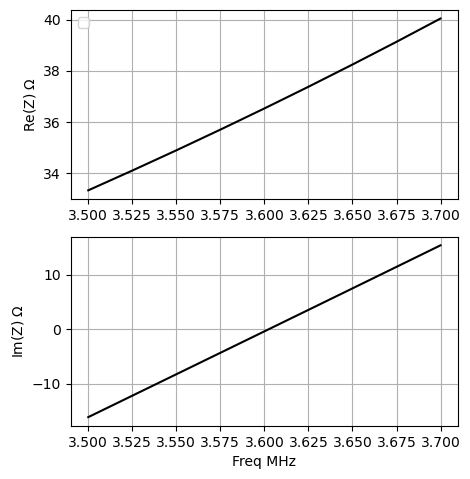

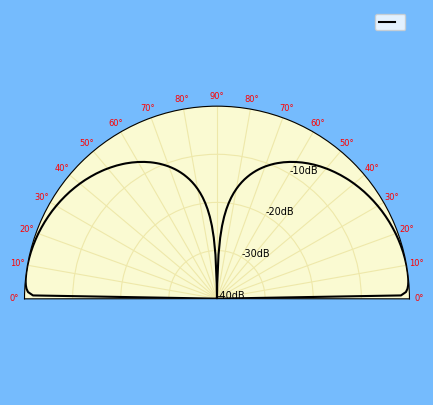

In [40]:

from necutil import in2m, ft2m, SolidAntenna, SolidObjVisualizer,nec5_sim_stdio3,plot_azimuth,plot_elevation,plot_complex_z
import numpy as np


# First look at a single 1/4wl vertical resonant at 3.6 MHz
vert1 = SolidAntenna(properties={'tubing_dia':in2m([2.125,2.0,1.875,1.75,1.625,1.5]),
                                 'section_lens':ft2m([10,10,10,10,10]),
                                 'color':'lightblue','boom':False,'seg_per_m':0.75}, n_elem=1)

# Create one element, rotate it to vertical
vert1[0] = {'len':20.4, 'rotate':[('x',90)]}    

# Get NEC cards and insert them into a NEC5 template...
nec_geom = vert1.get_nec_cards()   
nec_template = """CE Vertical
{gw_cards}
GE 1 0
GD 0 0 0 0 81 5.0 0 0
EX 4 1 1 1 1.0 0.0
FR 0 9 0 0 3.5 0.025
XQ 0
FR 0 1 0 0 3.6 0
RP 0 91 360 0000 0 0 1 1
EN
"""
nec_deck = nec_template.format(gw_cards=nec_geom.strip())

# ...and run the simulation
result = nec5_sim_stdio3([nec_deck])
rad_pat = result[0][1][0][0][1]                 # Extract just the radiation pattern array
peak_el = rad_pat[np.argmax(rad_pat[0:91,2])]   # Elevation of peak response
print(f'Elevation of peak response: {90-peak_el[0]}deg, {peak_el[2]} dBi')
plot_complex_z(result[0][0], tags='')
plot_elevation([rad_pat], tags=[''])




Next, a pair of 1/4&lambda; verticals, spacing = 1/4&lambda;, fed with the feed system described in:
* Lewallen, R. ["The Simplest Phased Array Feed System...That Works", *ARRL Antenna Compendium*, Vol. 2, pp.25-28](https://www.eznec.com/Amateur/Articles/Simpfeed.pdf)

Some future notebook will go into greater detail on computing optimum delay line lengths; for the present we'll use the values mentioned in the article: 80.56&deg; and 154.53&deg;.

Elevation of peak response: 9.0deg, 7.78 dBi


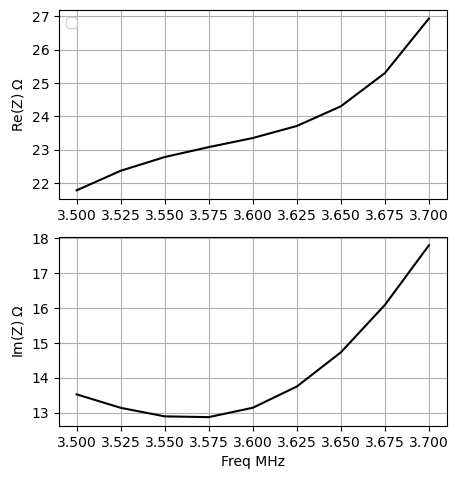

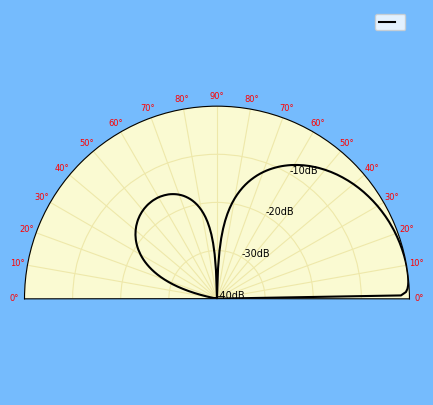

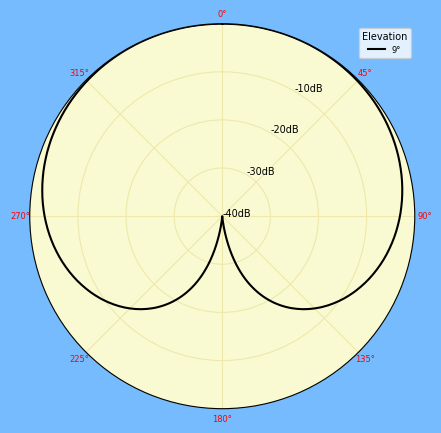

In [41]:

# A pair of 1/4wl verticals, spacing = 1/4wl, 
vert2 = SolidAntenna(properties={'tubing_dia':in2m([2.125,2.0,1.875,1.75,1.625,1.5]),
                                 'section_lens':ft2m([10,10,10,10,10]),
                                 'color':'lightblue','boom':False,'seg_per_m':0.75}, n_elem=2)

f_center = 3.6
wl = 299.792 / f_center
dl1 = wl * 154.53 / 360
dl2 = wl * 80.56 / 360
zo = 50
vert2[0] = {'len':20.4, 'rotate':[('x',90)], 'translate':(wl/8,0,0)}        # Spacing: 1/4wl
vert2[1] = {'len':20.4, 'rotate':[('x',90)], 'translate':(-wl/8,0,0)}    

# Get NEC cards and insert them into a NEC5 template...
gw_cards = vert2.get_nec_cards().strip()   
nec_template2 = f"""CE Verticals with delay lines
{gw_cards}
GW 99 2 0 0 1 0 0.001 1 0.001
GE 1 0
GD 0 0 0 0 81 5.0 0 0
TL 1 -1 99 1 {zo} {dl1} 0 0 0 0
TL 2 -1 99 1 {zo} {dl2} 0 0 0 0
EX 0 99 1 2 1.0 0.0
FR 0 9 0 0 3.5 0.025
XQ 0
FR 0 1 0 0 3.6 0
RP 0 91 360 0000 0 0 1 1
EN
"""
# ...and run the simulation
result = nec5_sim_stdio3([nec_template2])
rad_pat = result[0][1][0][0][1]                 # Extract just the radiation pattern array
peak_el = rad_pat[np.argmax(rad_pat[0:91,2])]   # Elevation of peak response
print(f'Elevation of peak response: {90-peak_el[0]}deg, {peak_el[2]} dBi')
plot_complex_z(result[0][0], tags='')
plot_elevation([rad_pat], tags=[''])
plot_azimuth(rad_pat, [9])


In [45]:
v = SolidObjVisualizer(x=(-12,12), y=(-12,12), z=(0,21))        # Sets the limits of displayed volume
v.add(vert2)
v.show()



<img src="img/2el_vertical.png" alt="Drawing" style="width: 400px;"/>